# Modified IQAE tests

In [1]:
import time
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from random import sample, seed
from collections import defaultdict

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, transpile, assemble
from qiskit.algorithms import amplitude_estimators, EstimationProblem
from qiskit.algorithms import IterativeAmplitudeEstimation as BaseIterativeAmplitudeEstimation

from algorithms import IterativeAmplitudeEstimation, ModifiedIterativeAmplitudeEstimation
from algorithms import NoQuantumIterativeAmplitudeEstimation
from operators import *

In [2]:
# Define the estimation problem and oracle function
def make_problems(n, marked):
    
    def good_state(state):
        bin_marked = [(n-len(bin(s))+2)*'0'+bin(s)[2:] for s in marked]
        return (state in bin_marked)

    problem = EstimationProblem(
        state_preparation=A(n),        # A operator
        grover_operator=Q(n, marked),  # Q operator
        objective_qubits=range(n),
        is_good_state=good_state       # the "good" state Psi1 is identified as measuring |1> in qubit 0
    )

    problem2 = EstimationProblem(
        state_preparation=A(n),  # A operator
        grover_operator=Q(n, marked),  # Q operator
        objective_qubits=range(n),
        is_good_state=good_state  # the "good" state Psi1 is identified as measuring |1> in qubit 0
    )
    
    return problem, problem2

In [3]:
# use local simulator
aer_sim = Aer.get_backend('aer_simulator')
shots = 100

## Compare Modified IQAE to No-Quantum IQAE

In [4]:
# parameters for IQAE

# number of experiments to run
n_experiments = 100

# amplitudes
n = 4
k = 2**n

# epsilons
powers = range(2,7)
epsilons = [(1.0 / (10**power)) for power in powers]

# other
alpha = 0.05
confint_method = 'beta'
verbose = False

In [5]:
def process_state(state, verbose=False):
    if verbose:
        for k,v in state.items():
            print(k)
            print(v)
    if len(state) == 0: return [],[],[]
    round_shots = state['round_shots']
    queries = state['n_queries']
    removed = False

    if 0 in round_shots:
        shots_at_k0 = round_shots.pop(0)
        removed = True
    if 0 in queries:
        queries_at_k0 = queries.pop(0)

    k_i = [k for k in round_shots]
    queries_i = [queries[k] for k in k_i]
    shots_i = ([shots_at_k0] if removed else []) + [round_shots[k] for k in k_i]

    if removed:
        k_i.insert(0, 0.1)

    return shots_i, queries_i, k_i

In [6]:
def experiment(plots=False, add_noise=False, verbose=False):
    
    # stats recording
    iae_epsilon = []
    iae_nshots = []
    miae_epsilon = []
    miae_nshots = []

    exprs = ['Modified IAE', 'Original IAE']

    wins = matches = 0

    tdelta = 0

    ki = 0
    while ki <= k:

        # setup problems with specified N,k
        N = max(128, 2**n)
        
        if add_noise:
            noise = np.random.uniform(-0.05 if ki > 0 else 0, 0.05 if ki < k else 0) * N
            marked = sample(range(k*N), int(max(0, min(k*N, ki*N + noise))))
            problem, problem2 = make_problems(int(np.log2(N)), marked)
            if verbose:
                print('with noise:', int(max(0, min(k*N, ki*N + noise))) / (k*N) )
                print('without noise:', (ki*N) / (k*N))
            
            # set N back to old definition
            N = 2**n
            
        else:
            N = 2**n
            marked = sample(range(N), ki)
            problem, problem2 = make_problems(n, marked)
            
        

        # execute experiments for each power
        miae_results = defaultdict(list)
        iae_results = defaultdict(list)

        for i, epsilon in enumerate(epsilons):
            
            if plots:
                fig,axs = plt.subplots(1,3,figsize=(15,5))

                fig.suptitle(f'a={ki/N}, eps={epsilon}')
                axs[0].set_xscale('log')
                axs[0].set_title('Shots_i vs. k_i')

                axs[1].set_xscale('log')
                axs[1].set_yscale('log')
                axs[1].set_title('Queries_i vs. k_i')

                axs[2].set_yscale('log')
                axs[2].set_title('k_i vs. i')

            n_entries = 0
            for confint_method in ['chernoff', 'beta']:

                if verbose:
                    print('ε:',epsilon)

                MIAE = ModifiedIterativeAmplitudeEstimation(epsilon_target=epsilon, 
                                                            alpha=alpha, 
                                                            confint_method=confint_method, 
                                                            quantum_instance=aer_sim)

                IAE = IterativeAmplitudeEstimation(epsilon_target=epsilon, 
                                                            alpha=alpha, 
                                                            confint_method=confint_method, 
                                                            quantum_instance=aer_sim)

                # configure the number of shots this way and pray that it works
                MIAE._quantum_instance._run_config.shots = shots
                IAE._quantum_instance._run_config.shots = shots

                # for recording intermediate algo results
                state = defaultdict(dict)
                state2 = defaultdict(dict)

                miae_result = MIAE.estimate(problem,
                                            state=state,
                                            verbose=verbose)

                iae_result = IAE.estimate(problem2,
                                          state=state2,
                                          verbose=verbose)

                miae_results[confint_method].append(miae_result)
                iae_results[confint_method].append(iae_result)

                if verbose:
                    print()

                mod_shots, mod_queries, mod_k = process_state(state)
                base_shots, base_queries, base_k = process_state(state2)

                if plots:
                     # plots for shots vs k
                    axs[0].plot(mod_k, mod_shots, label=f'{confint_method.title()} modified')
                    axs[0].scatter(mod_k, mod_shots)
                    axs[0].plot(base_k, base_shots, label=f'{confint_method.title()} base')
                    axs[0].scatter(base_k, base_shots)

                    # plots for nqueries vs k
                    axs[1].plot(mod_k, mod_queries, label=f'{confint_method.title()} modified')
                    axs[1].scatter(mod_k, mod_queries)
                    axs[1].plot(base_k[1:], base_queries, label=f'{confint_method.title()} base')
                    axs[1].scatter(base_k[1:], base_queries)

                    # plots for k
                    axs[2].plot(mod_k, label=f'{confint_method.title()} modified')
                    axs[2].scatter(range(len(mod_k)), mod_k)
                    axs[2].plot(base_k, label=f'{confint_method.title()} base')
                    axs[2].scatter(range(len(base_k)), base_k)


                n_entries = max(len(base_k), len(mod_k), n_entries)

            if plots:
                for i in range(3): axs[i].legend()
                axs[2].plot(range(n_entries), np.repeat(np.pi / 4 / epsilon, n_entries), c='r', linestyle='--')

        
        if plots:
            # process results
            plt.figure(figsize=(15,7))
            plt.yscale('log')
        #     plt.ylim(10**4, 10**10)
            plt.xscale('log')

            plt.xlim(epsilons[0]*2, epsilons[-1]/2)
            plt.title(f'{"Noisy " if add_noise else ""}Error vs. Number of Queries')

        miae_epsilon_i = {}
        miae_nshots_i = {}
        iae_epsilon_i = {}
        iae_nshots_i = {}
        
        for confint_method in ['chernoff', 'beta']:
            miae_epsilon_i[confint_method] = [(res.confidence_interval_processed[1] - res.confidence_interval_processed[0]) / 2 for res in miae_results[confint_method]]
            miae_nshots_i[confint_method]  = [res.num_oracle_queries for res in miae_results[confint_method]]

            iae_epsilon_i[confint_method] = [(res.confidence_interval_processed[1] - res.confidence_interval_processed[0]) / 2 for res in iae_results[confint_method]]
            iae_nshots_i[confint_method]  = [res.num_oracle_queries for res in iae_results[confint_method]]

            if verbose:
                print(f'a: {ki}/{2**n} = {ki/2**n}')
                print(f'{exprs[0]} estimations:', [res.estimation for res in miae_results[confint_method]])
                print(f'{exprs[1]} estimations:', [res.estimation for res in iae_results[confint_method]])

            miae_total_queries, iae_total_queries = sum(miae_nshots_i[confint_method]), sum(iae_nshots_i[confint_method])
            
            if verbose:
                print(f'{exprs[0]} total queries:', miae_total_queries)
                print(f'{exprs[1]} total queries:', iae_total_queries)

                print(f'{exprs[0]} epsilons (CI width):', miae_epsilon_i)
                print(f'{exprs[1]} epsilons (CI width):', iae_epsilon_i)

            diff = round(abs(iae_total_queries - miae_total_queries) / miae_total_queries * 100, 2)
        #     print('Modified version wins?', iae_total_queries < miae_total_queries, f'with {diff}% difference')

            wins += int(iae_total_queries < miae_total_queries)
            matches += 1

            if plots:
                # plots for query complexity, shots per k

                # plot query complexity
                plt.scatter(epsilons, miae_nshots_i[confint_method])
                plt.plot(epsilons, miae_nshots_i[confint_method], label=f'{confint_method.title()} modified')
                plt.scatter(epsilons, iae_nshots_i[confint_method])
                plt.plot(epsilons, iae_nshots_i[confint_method], label=f'{confint_method.title()} base')

        if plots:
            plt.legend()
            plt.show()

        # save results for epsilon vs nshots
        miae_nshots.append(miae_nshots_i)
        miae_epsilon.append(miae_epsilon_i)
        iae_nshots.append(iae_nshots_i)
        iae_epsilon.append(iae_epsilon_i)

        ki += 1

#     iae_nshots = np.array(iae_nshots)
    
    return { 
        'miae_nshots': miae_nshots, 
        'miae_epsilon': miae_epsilon,
        'iae_nshots': iae_nshots,
        'iae_epsilon': iae_epsilon
    }

    # print('% modified > 3x modified:', wins/matches)

In [7]:
res = []
for _ in tqdm(range(n_experiments)):
    res_i = experiment(add_noise=True)
    res.append(res_i)

100%|██████████| 1/1 [03:17<00:00, 197.16s/it]


# Query complexity

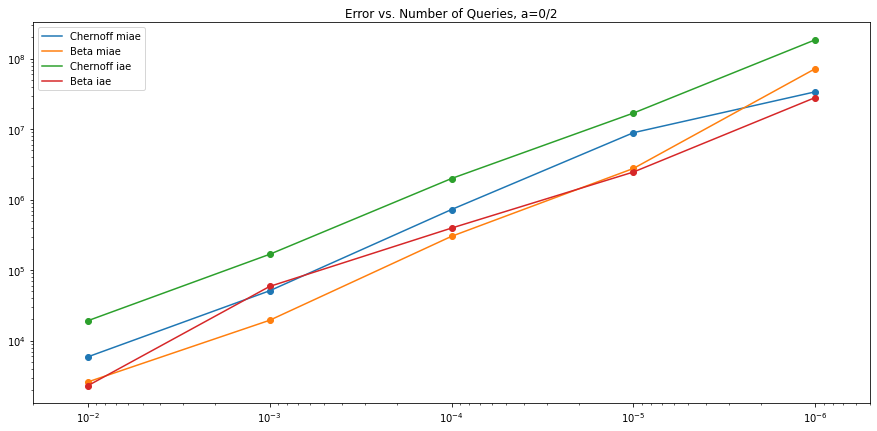

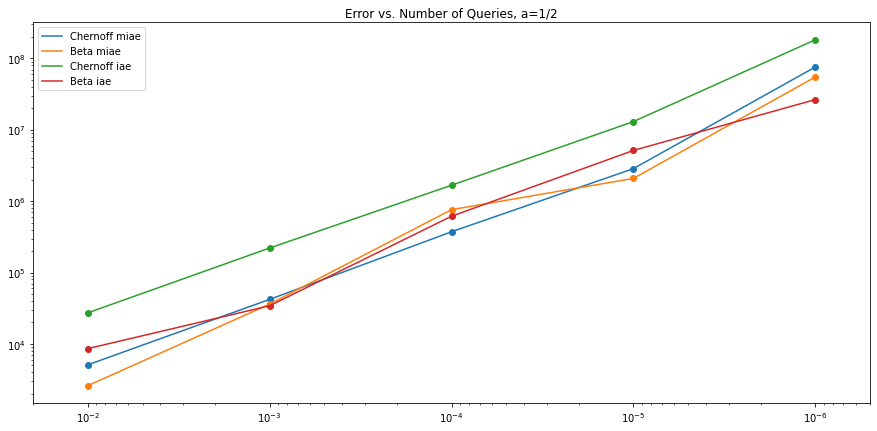

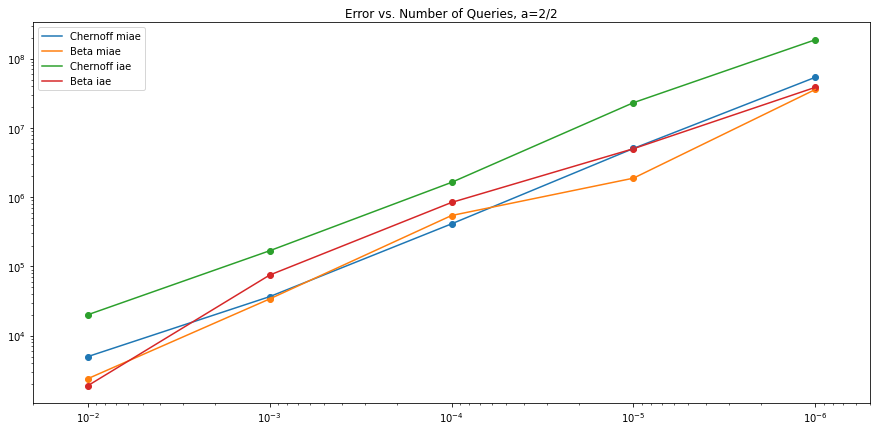

In [16]:
amplitudes = np.arange(k+1)

for a in amplitudes:
    lines = []
    
    plt.figure(figsize=(15,7))
    plt.yscale('log')
#     plt.ylim(10**4, 10**10)
    plt.xscale('log')

    plt.xlim(epsilons[0]*2, epsilons[-1]/2)
    plt.title(f'Error vs. Number of Queries, a={a}/{k}')
    
    for expr in ['miae', 'iae']:
        for confint in ['chernoff', 'beta']:
            queries = np.array([[res_expr_i[confint] for res_expr_i in res_i[f'{expr}_nshots']][a] for res_i in res]).mean(axis=0)
            plt.scatter(epsilons, queries)
            line, = plt.plot(epsilons, queries, label=f'{confint.title()} {expr}')
            lines.append(line)
    
    plt.legend()
    
    plt.savefig(f'results_images/err-vs-queries_{a}-{k}.png')
    # plt.show()

# Query count vs. input amplitude

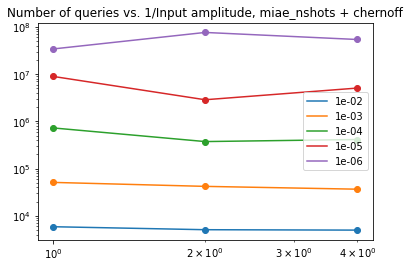

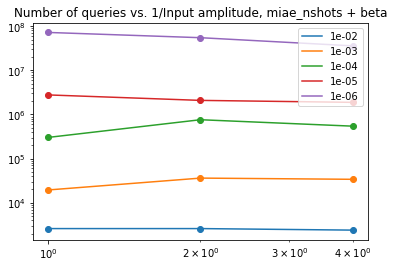

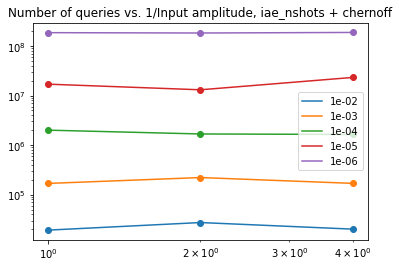

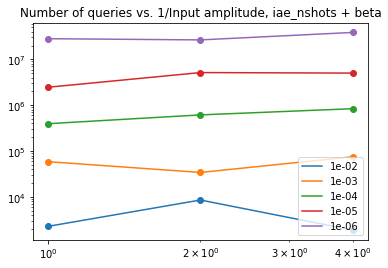

In [17]:
for expr in ['miae_nshots', 'iae_nshots']:
    for confint in ['chernoff', 'beta']:
        
        plt.figure()
        arr = np.array([[res_expr_i[confint] for res_expr_i in res_i[expr]] for res_i in res]).mean(axis=0)

        lines = []
        for i,eps in enumerate(epsilons):
            line, = plt.plot(2**np.arange(arr.shape[0]), arr[:,i], label='{:.0e}'.format(eps))
            plt.scatter(2**np.arange(arr.shape[0]), arr[:,i])
            lines.append(line)

        plt.title(f'Number of queries vs. 1/Input amplitude, {expr} + {confint}')
        plt.legend(handles=lines)
        plt.xscale('log')
        plt.yscale('log')

        # plt.show()
        plt.savefig(f'results_images/queries-vs-a_{expr}-{confint}')